In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
from utilities import *
from dissipative_utils import *

This notebook contains code to visualize MNO predictions on the Lorenz-63 system and compare them to baseline models. While the code is written specifically for visualizing predictions on the Lorenz-63 system, the notebook can easily be adapted to visualizing predictions on other finite-dimensional ODE systems, or even on infinite-dimensional systems visualized under PCA or another method of dimensionality reduction.

In [2]:
# Load data
predloader = MatReader('../data/L63T10000.mat')
data = predloader.read_field('u')
data = data.numpy()

# Visualizing Learned Vector Fields

In [3]:
# Fineness of grid to be sampled on
grid_sub = 17 

# Upper and lower bounds of the grid
upper = 150.
lower = -150.

# Whether to show the dissipative shell for MNO
plot_diss_shell = False
inner_radius = 90
outer_radius = inner_radius + 40

# Dimensionality of the output space
out_dim = 3

# Subsample for plotting the attractor of the data
sub = 128 * 10
data_sub = data[::sub]

In [4]:
# Model path
path = 'MODEL_PATH'
model = torch.load('/path/to/model/directory/' + path)

In [5]:
# Create grid
x,y,z =  np.meshgrid(np.linspace(lower, upper, grid_sub), np.linspace(lower, upper, grid_sub), np.linspace(lower, upper, grid_sub), indexing='ij')

# Generate predictions on the grid
x_out,y_out,z_out =  np.meshgrid(np.linspace(lower, upper, grid_sub), np.linspace(lower, upper, grid_sub), np.linspace(lower, upper, grid_sub), indexing='ij')

with torch.no_grad():
    for i, j, k in np.ndindex((grid_sub, grid_sub, grid_sub)):
        input_arr = torch.tensor(np.array([x[i][j][k], y[i][j][k], z[i][j][k]]), dtype=torch.float)#.cuda()
        pred = model(input_arr).reshape(out_dim,).cpu().numpy()
        # Resulting vector
        x_out[i][j][k] = pred[0] - x[i][j][k]
        y_out[i][j][k] = pred[1] - y[i][j][k]
        z_out[i][j][k] = pred[2] - z[i][j][k]

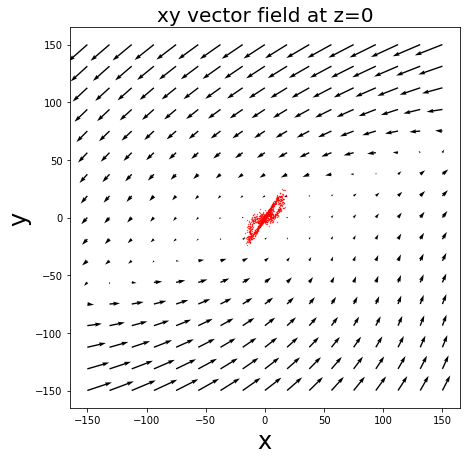

In [6]:
# Plot xy
x,y = np.meshgrid(np.linspace(lower, upper, grid_sub), np.linspace(lower, upper, grid_sub))
fig = plt.figure(figsize=(7,7))
ax = fig.gca()
ax.quiver(x, y, y_out[:,:,grid_sub//2], x_out[:,:,grid_sub//2], scale=1000, scale_units='inches') # swapped x and y because ij indexing transposes
ax.scatter(data_sub[:,0], data_sub[:,1], s=0.1, c='r')

if plot_diss_shell:
    ax.add_patch(plt.Circle((0,0), inner_radius, color='b', fill=False))
    ax.add_patch(plt.Circle((0,0), outer_radius, color='b', fill=False))

plt.xlabel('x', fontsize=24)
plt.ylabel('y', fontsize=24)
plt.title('xy vector field at z=0', fontsize=20)
plt.show()

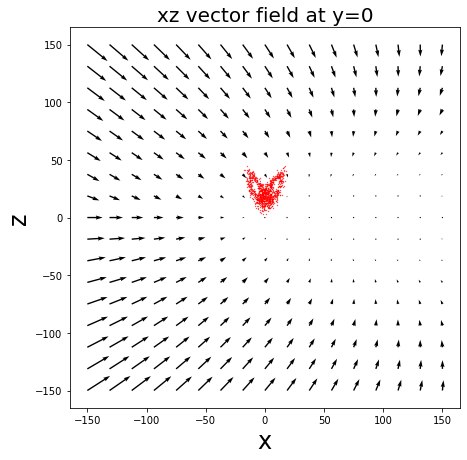

In [7]:
# Plot xz
x,z = np.meshgrid(np.linspace(lower, upper, grid_sub), np.linspace(lower, upper, grid_sub))
fig = plt.figure(figsize=(7,7))
ax = fig.gca()
ax.quiver(x, z, z_out[:,grid_sub//2,:], x_out[:,grid_sub//2,:], scale=1000, scale_units='inches') # swapped x and z because ij indexing transposes
ax.scatter(data_sub[:,0], data_sub[:,2], s=0.1, c='r')

if plot_diss_shell:
    ax.add_patch(plt.Circle((0,0), inner_radius, color='b', fill=False))
    ax.add_patch(plt.Circle((0,0), outer_radius, color='b', fill=False))

plt.xlabel('x', fontsize=24)
plt.ylabel('z', fontsize=24)
plt.title('xz vector field at y=0', fontsize=20)
plt.show()

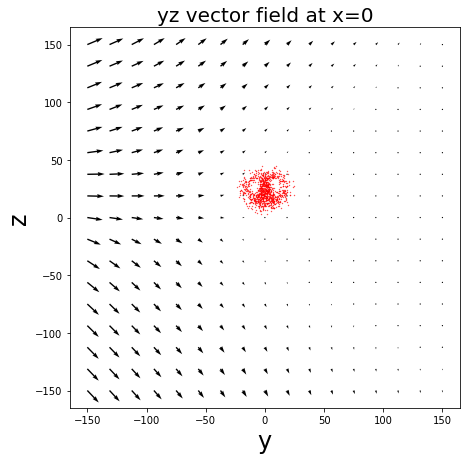

In [8]:
y,z = np.meshgrid(np.linspace(lower, upper, grid_sub), np.linspace(lower, upper, grid_sub))
fig = plt.figure(figsize=(7,7))
ax = fig.gca()
ax.quiver(y, z, z_out[grid_sub//2,:,:], y_out[grid_sub//2,:,:], scale=1000, scale_units='inches') # swapped y and z because ij indexing transposes
ax.scatter(data_sub[:,1], data_sub[:,2], s=0.1, c='r')

if plot_diss_shell:
    ax.add_patch(plt.Circle((0,0), inner_radius, color='b', fill=False))
    ax.add_patch(plt.Circle((0,0), outer_radius, color='b', fill=False))

plt.xlabel('y', fontsize=24)
plt.ylabel('z', fontsize=24)
plt.title('yz vector field at x=0', fontsize=20)
plt.show()

# Visualizing Learned Vector Fields with Post-Processing Dissipativity

In [9]:
# Post-processing params
sigmoid_shift = 100
sigmoid_scale = 0.1
diss_scale = 0.5 # lambda
plot_sigmoid_shift = True
plot_radius = sigmoid_shift

# Post-processing functions
rho = lambda norm_x : sigmoid_partition_unity(norm_x, sigmoid_shift, sigmoid_scale)
diss = lambda x : linear_scale_dissipative_target(x, diss_scale)

In [10]:
# Create grid
x,y,z =  np.meshgrid(np.linspace(lower, upper, grid_sub), np.linspace(lower, upper, grid_sub), np.linspace(lower, upper, grid_sub), indexing='ij')

# Generate predictions
x_out,y_out,z_out =  np.meshgrid(np.linspace(lower, upper, grid_sub), np.linspace(lower, upper, grid_sub), np.linspace(lower, upper, grid_sub), indexing='ij')

with torch.no_grad():
    for i, j, k in np.ndindex((grid_sub, grid_sub, grid_sub)):
        input_arr = torch.tensor(np.array([x[i][j][k], y[i][j][k], z[i][j][k]]), dtype=torch.float)#.cuda()
        pred = part_unity_post_process(input_arr, model, rho, diss).reshape(out_dim,).cpu().numpy()
        # Resulting vector
        x_out[i][j][k] = pred[0] - x[i][j][k]
        y_out[i][j][k] = pred[1] - y[i][j][k]
        z_out[i][j][k] = pred[2] - z[i][j][k]

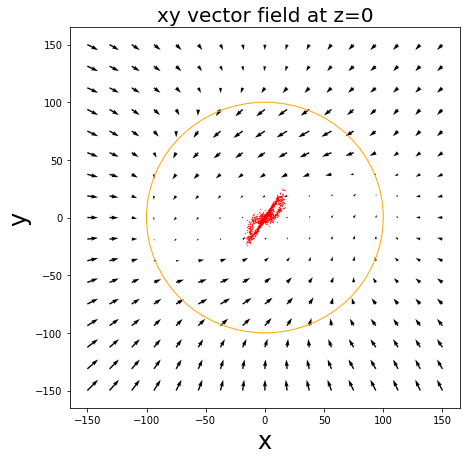

In [11]:
# Plot xy
x,y = np.meshgrid(np.linspace(lower, upper, grid_sub), np.linspace(lower, upper, grid_sub))
fig = plt.figure(figsize=(7,7))
ax = fig.gca()
ax.quiver(x, y, y_out[:,:,grid_sub//2], x_out[:,:,grid_sub//2], scale=1000, scale_units='inches') # swapped x and y because ij indexing transposes
ax.scatter(data_sub[:,0], data_sub[:,1], s=0.1, c='r')

if plot_sigmoid_shift:
    ax.add_patch(plt.Circle((0,0), plot_radius, color='orange', fill=False))

plt.xlabel('x', fontsize=24)
plt.ylabel('y', fontsize=24)
plt.title('xy vector field at z=0', fontsize=20)
plt.show()

# Semi-Log Plots for Learned Lorenz Distributions

To generate histogram or density plots of the predictions, it is useful to have predictions for the models in question of a single trajectory of around 10000 seconds. Only a single trajectory is necessary for systems where the invariant statistics remain stationary over time.

In [12]:
# Load predictions
dissipative_pred = np.load('/path/to/dissipative/predictions.npy')
baseline_pred = np.load('/path/to/baseline/predictions.npy')

Just to be safe, we'll first remove the first few seconds of the trajectory, to ensure that the predictions have had time to return to the attractor.

In [13]:
diss_pred = dissipative_pred[100:]
base_pred = baseline_pred[100:]

# Subsample data to reduce computational complexity
data_sub = data[::6]

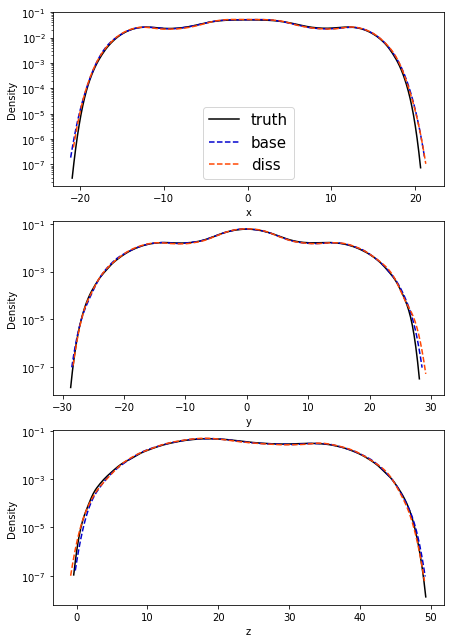

In [14]:
# Generate semi-log plots
fig, axs = plt.subplots(3)
fig.set_figheight(8)
fig.set_figwidth(7)
fig.subplots_adjust(bottom=-0.15)

sns.kdeplot(data[:,0], ax=axs[0], label='truth', color='black', log_scale=(0,10))
sns.kdeplot(base_pred[:,0], ax=axs[0], label='base', color='mediumblue', log_scale=(0,10), linestyle='dashed')
sns.kdeplot(diss_pred[:,0], ax=axs[0], label='diss', color='orangered', log_scale=(0,10), linestyle='dashed')
axs[0].set_xlabel('x')
axs[0].legend(loc='lower center', prop={'size': 15})

sns.kdeplot(data[:,1], ax=axs[1], label='truth', color='black', log_scale=(0,10))
sns.kdeplot(base_pred[:,1], ax=axs[1], label='base', color='mediumblue', log_scale=(0,10), linestyle='dashed')
sns.kdeplot(diss_pred[:,1], ax=axs[1], label='diss', color='orangered', log_scale=(0,10), linestyle='dashed')
axs[1].set_xlabel('y')

sns.kdeplot(data[:,2], ax=axs[2], label='truth', color='black', log_scale=(0,10))
sns.kdeplot(base_pred[:,2], ax=axs[2], label='base', color='mediumblue', log_scale=(0,10), linestyle='dashed')
sns.kdeplot(diss_pred[:,2], ax=axs[2], label='diss', color='orangered', log_scale=(0,10), linestyle='dashed')
axs[2].set_xlabel('z')

plt.show()

# Learned Lorenz Distributions Without Semi-Log Scaling

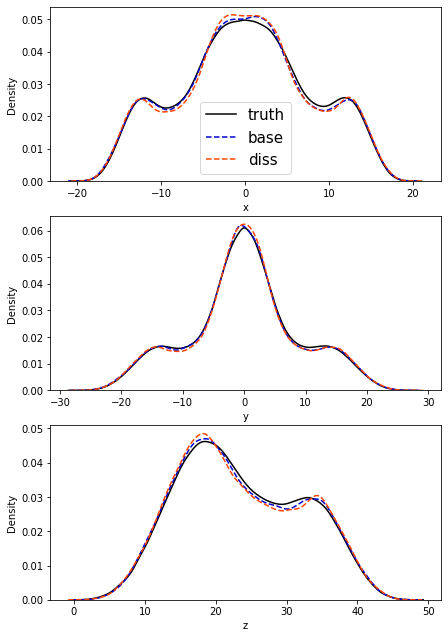

In [15]:
# Generate plots with linear scaling
fig, axs = plt.subplots(3)
fig.set_figheight(8)
fig.set_figwidth(7)
fig.subplots_adjust(bottom=-0.15)

sns.kdeplot(data[:,0], ax=axs[0], label='truth', color='black')
sns.kdeplot(base_pred[:,0], ax=axs[0], label='base', color='mediumblue', linestyle='dashed')
sns.kdeplot(diss_pred[:,0], ax=axs[0], label='diss', color='orangered', linestyle='dashed')
axs[0].set_xlabel('x')
axs[0].legend(loc='lower center', prop={'size': 15})

sns.kdeplot(data[:,1], ax=axs[1], label='truth', color='black')
sns.kdeplot(base_pred[:,1], ax=axs[1], label='base', color='mediumblue', linestyle='dashed')
sns.kdeplot(diss_pred[:,1], ax=axs[1], label='diss', color='orangered', linestyle='dashed')
axs[1].set_xlabel('y')

sns.kdeplot(data[:,2], ax=axs[2], label='truth', color='black')
sns.kdeplot(base_pred[:,2], ax=axs[2], label='base', color='mediumblue', linestyle='dashed')
sns.kdeplot(diss_pred[:,2], ax=axs[2], label='diss', color='orangered', linestyle='dashed')
axs[2].set_xlabel('z')

plt.show()